# Gaussian Kernel Approximation with Random Fourier Features

This Jupyter notebook demonstrates the concept of using Random Fourier Features (RFF) to approximate the Gaussian kernel, as introduced in the seminal paper:

>Rahimi, Ali and Recht, Benjamin, "Random features for large-scale kernel machines", Advances in neural information processing systems, vol. 20, 2007.

The Gaussian kernel is a popular choice in various machine learning applications, particularly because of its properties of smoothness and locality. The kernel function is defined as:

$$ k(\tau) = e^{-\frac{\|\tau\|^2}{2}} $$

where $ \tau $ is the difference between two points in the input space. The power spectrum of the Gaussian kernel, which is its Fourier transform, is also Gaussian:

$$ p(\omega) = (2\pi)^{-\frac{D}{2}} e^{-\frac{\|\omega\|^2}{2}} $$

where $ \omega $ represents frequency components and $ D $ is the dimensionality of the input space.

The idea behind RFF is to use a finite number of random samples from this power spectrum to create a feature map that approximates the kernel. This allows us to use kernel methods efficiently with large-scale datasets.

This notebook is prepared by Ryan Farell as a demonstration of the RFF technique, aiming to provide a hands-on understanding of the concept and its implementation.

## Credits
- **Original Paper Authors**: Ali Rahimi and Benjamin Recht
- **Notebook Creator**: Ryan Farell

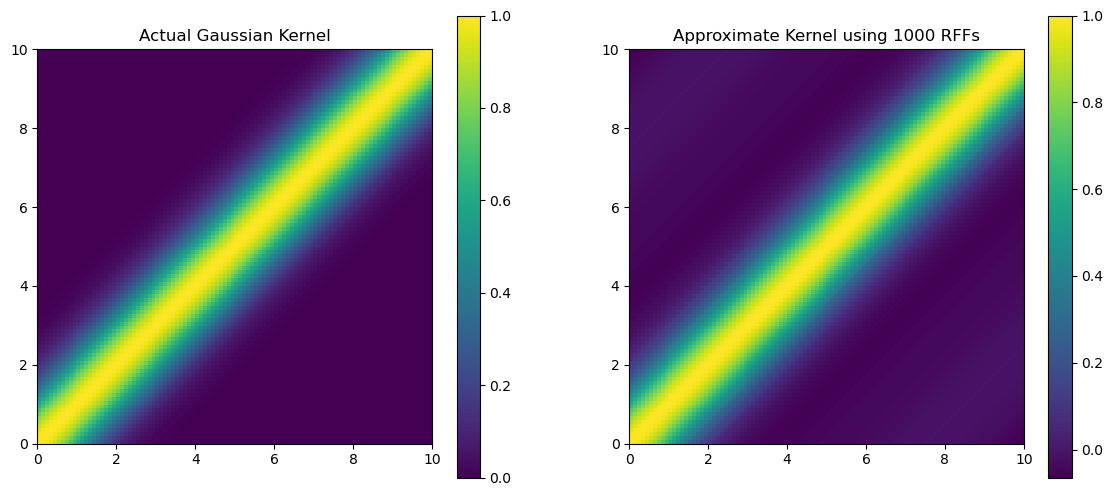

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian kernel function
def gaussian_kernel(tau):
    return np.exp(-np.linalg.norm(tau)**2 / 2)

# Sample D points from the power spectrum pdf to generate a random feature map
def sample_omega(D, dimension):
    # The Gaussian power spectrum is the Fourier Transform of the Gaussian kernel
    # For Gaussian kernel, the power spectrum is also Gaussian
    omega = np.random.normal(loc=0.0, scale=1, size=(D, dimension))
    return omega

# Compute the approximate kernel using the random feature map
def approximate_kernel(X, omega, D):
    Z = np.sqrt(1/D) * np.hstack((np.cos(X @ omega.T), np.sin(X @ omega.T)))
    return Z @ Z.T

# Define the function to plot the actual and approximate kernels
def plot_kernels(x, D):
    # Compute the actual kernel matrix
    actual_kernel = np.array([[gaussian_kernel(x1 - x2) for x1 in x] for x2 in x])

    # Sample omega from the power spectrum
    omega = sample_omega(D, 1)

    # Compute the approximate kernel matrix using random Fourier features
    approx_kernel = approximate_kernel(x[:, np.newaxis], omega, D)

    # Plot the actual kernel heatmap
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(actual_kernel, extent=(x[0], x[-1], x[0], x[-1]), origin='lower')
    plt.colorbar()
    plt.title('Actual Gaussian Kernel')

    # Plot the approximate kernel heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(approx_kernel, extent=(x[0], x[-1], x[0], x[-1]), origin='lower')
    plt.colorbar()
    plt.title('Approximate Kernel using {} RFFs'.format(D))
    plt.savefig('rff_kernel.png')


# Set the dimension of the feature space
D = 1000  # Dimension of the feature map
x = np.linspace(0, 10, 100)  # Range of x values

# Call the function to plot the kernels
plot_kernels(x, D)


## Convergence Analysis of Kernel Approximation Errors

In this section, we analyze the convergence of the total error and the worst-case error as the number of random features \( D \) increases. The total error is computed as the sum of absolute differences between the actual kernel and the approximate kernel across all pairs of points. Similarly, the worst-case error is determined by the maximum absolute difference between the two kernels for any pair of points.

As the plots below demonstrate, both the total error and the worst-case error tend to converge towards zero with increasing \( D \). This empirical observation aligns with the theoretical underpinnings of Random Fourier Features (RFF), which suggest that as we increase the number of features, the approximate representation becomes more accurate, thus better capturing the characteristics of the Gaussian kernel.


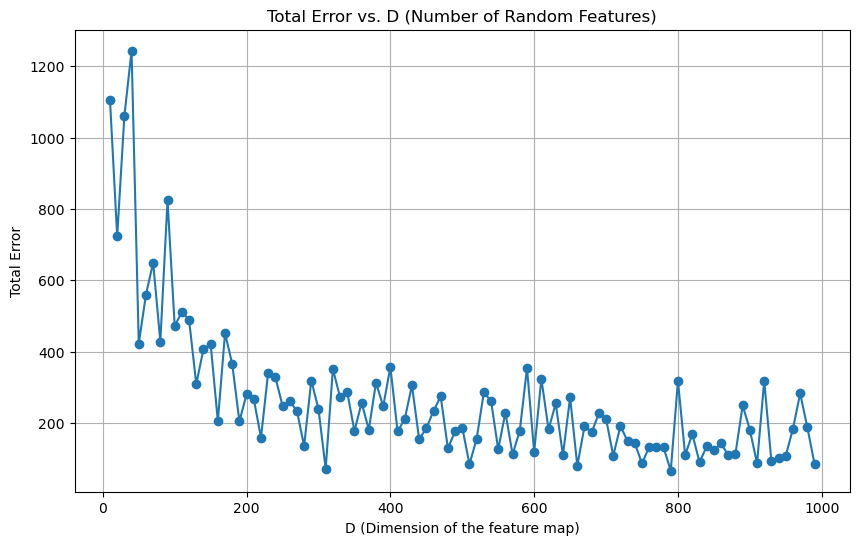

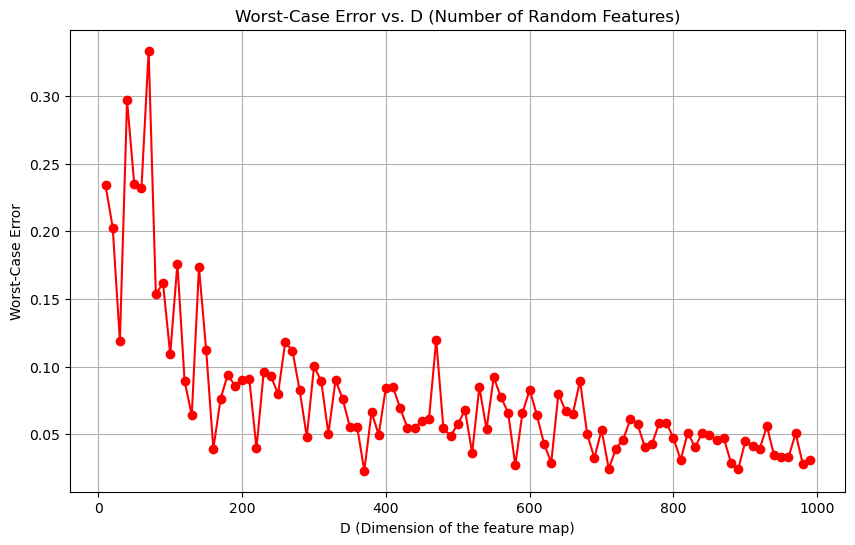

In [2]:

# Define the function to calculate total error between actual and approximate kernels
def calculate_total_error(x, D_values):
    actual_kernel = np.array([[gaussian_kernel(x1 - x2) for x1 in x] for x2 in x])
    errors = []
    
    for D in D_values:
        omega = sample_omega(D, 1)
        approx_kernel = approximate_kernel(x[:, np.newaxis], omega, D)
        error = np.sum(np.abs(actual_kernel - approx_kernel))
        errors.append(error)
    
    return errors

# Set the dimension of the feature space and range of D values
D_values = range(10, 1000, 10)  # Range of D values
x = np.linspace(0, 10, 100)  # Range of x values

# Calculate the total error for different D values
total_errors = calculate_total_error(x, D_values)

# Plot total error against D values
plt.figure(figsize=(10, 6))
plt.plot(D_values, total_errors, marker='o')
plt.xlabel('D (Dimension of the feature map)')
plt.ylabel('Total Error')
plt.title('Total Error vs. D (Number of Random Features)')
plt.grid(True)
plt.savefig('rff_error.png')

# Define the function to calculate worst-case error between actual and approximate kernels
def calculate_worst_case_error(x, D_values):
    actual_kernel = np.array([[gaussian_kernel(x1 - x2) for x1 in x] for x2 in x])
    worst_case_errors = []
    
    for D in D_values:
        omega = sample_omega(D, 1)
        approx_kernel = approximate_kernel(x[:, np.newaxis], omega, D)
        error = np.max(np.abs(actual_kernel - approx_kernel))
        worst_case_errors.append(error)
    
    return worst_case_errors

# Calculate the worst-case error for different D values
worst_case_errors = calculate_worst_case_error(x, D_values)

# Plot worst-case error against D values
plt.figure(figsize=(10, 6))
plt.plot(D_values, worst_case_errors, marker='o', color='red')
plt.xlabel('D (Dimension of the feature map)')
plt.ylabel('Worst-Case Error')
plt.title('Worst-Case Error vs. D (Number of Random Features)')
plt.grid(True)
plt.savefig('rff_worst_case_error.png')

## Posterior Predictive Distribution

In this section, we demonstrate the use of RFF to approximate the Gaussian kernel in a Bayesian setting. We use the RFF to approximate the kernel in a Gaussian Process (GP) model and compare the posterior predictive distribution with the true distribution. The results show that the RFF-based GP model provides a good approximation of the true distribution, thus demonstrating the effectiveness of the RFF technique in practical applications.

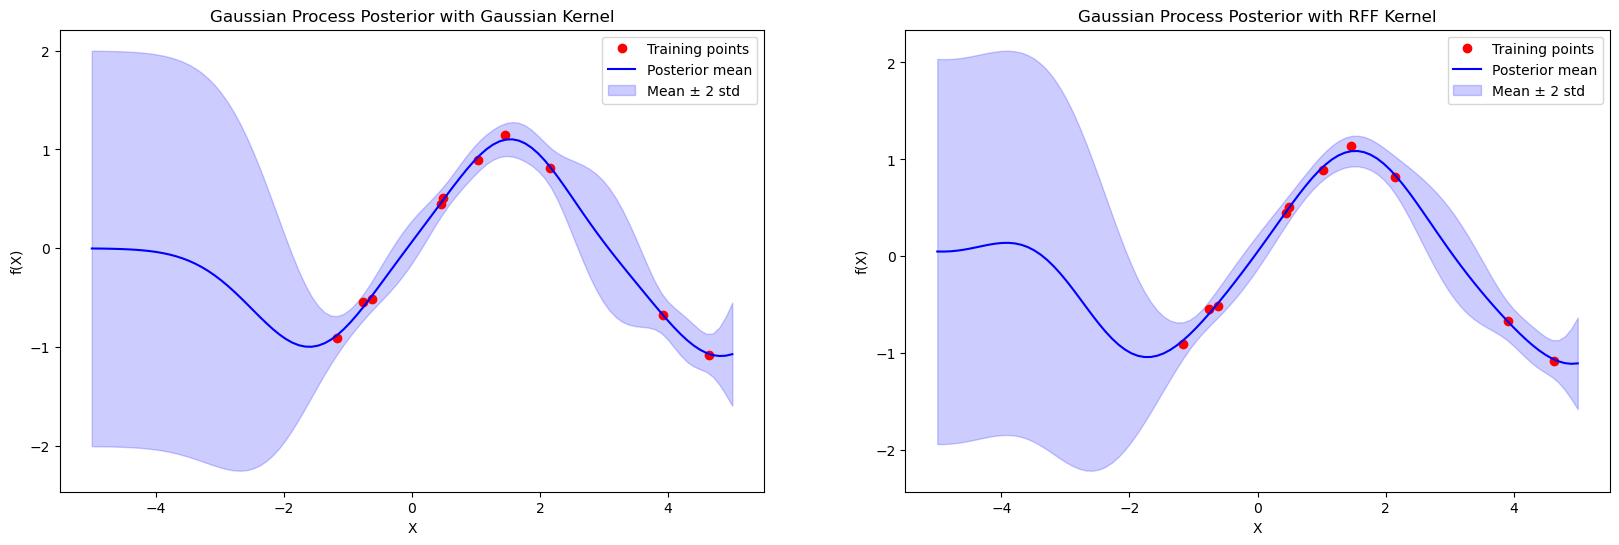

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Kernel function
def gaussian_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * np.linalg.norm(x1 - x2)**2 / length_scale**2)

# RFF Kernel functions
def sample_omega(D, dimension):
    omega = np.random.normal(loc=0.0, scale=1, size=(D, dimension))
    return omega

def approximate_kernel(X1, X2, omega, D):
    Z1 = np.sqrt(1/D) * np.hstack((np.cos(X1 @ omega.T), np.sin(X1 @ omega.T)))
    Z2 = np.sqrt(1/D) * np.hstack((np.cos(X2 @ omega.T), np.sin(X2 @ omega.T)))
    return Z1 @ Z2.T

# Generate covariance matrix
def generate_covariance_matrix(X1, X2, kernel_function):
    num_points_X1 = len(X1)
    num_points_X2 = len(X2)
    covariance_matrix = np.zeros((num_points_X1, num_points_X2))
    for i in range(num_points_X1):
        for j in range(num_points_X2):
            covariance_matrix[i, j] = kernel_function(X1[i], X2[j])
    return covariance_matrix

# Shared parameters
N = 10  # Sample points
noise_std = 0.1  # Noise standard deviation
np.random.seed(0)
X_train = np.sort(np.random.uniform(-5, 5, N))
Y_train = np.sin(X_train) + np.random.normal(0, noise_std, N)
X_pred = np.linspace(-5, 5, 100)

# Gaussian Kernel Computations
K_gauss = generate_covariance_matrix(X_train, X_train, gaussian_kernel) + noise_std**2 * np.eye(N)
K_s_gauss = generate_covariance_matrix(X_train, X_pred, gaussian_kernel)
K_ss_gauss = generate_covariance_matrix(X_pred, X_pred, gaussian_kernel)
K_inv_gauss = np.linalg.inv(K_gauss)
mu_s_gauss = K_s_gauss.T @ K_inv_gauss @ Y_train
cov_s_gauss = K_ss_gauss - K_s_gauss.T @ K_inv_gauss @ K_s_gauss
std_s_gauss = np.sqrt(np.diag(cov_s_gauss))

# RFF Kernel Computations
D = 100  # Number of random features
omega = sample_omega(D, 1)
X_train_rff = X_train[:, np.newaxis]
X_pred_rff = X_pred[:, np.newaxis]
K_rff = approximate_kernel(X_train_rff, X_train_rff, omega, D) + noise_std**2 * np.eye(N)
K_s_rff = approximate_kernel(X_train_rff, X_pred_rff, omega, D)
K_ss_rff = approximate_kernel(X_pred_rff, X_pred_rff, omega, D)
K_inv_rff = np.linalg.inv(K_rff)
mu_s_rff = K_s_rff.T @ K_inv_rff @ Y_train
cov_s_rff = K_ss_rff - K_s_rff.T @ K_inv_rff @ K_s_rff
std_s_rff = np.sqrt(np.diag(cov_s_rff))

# Plotting
plt.figure(figsize=(20, 6))

# Gaussian Kernel Plot
plt.subplot(1, 2, 1)
plt.plot(X_train, Y_train, 'ro', label='Training points')
plt.plot(X_pred, mu_s_gauss, 'b-', label='Posterior mean')
plt.fill_between(X_pred, mu_s_gauss - 2*std_s_gauss, mu_s_gauss + 2*std_s_gauss, color='blue', alpha=0.2, label='Mean ± 2 std')
plt.title('Gaussian Process Posterior with Gaussian Kernel')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()

# RFF Kernel Plot
plt.subplot(1, 2, 2)
plt.plot(X_train, Y_train, 'ro', label='Training points')
plt.plot(X_pred, mu_s_rff, 'b-', label='Posterior mean')
plt.fill_between(X_pred.ravel(), mu_s_rff - 2*std_s_rff, mu_s_rff + 2*std_s_rff, color='blue', alpha=0.2, label='Mean ± 2 std')
plt.title('Gaussian Process Posterior with RFF Kernel')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()

plt.show()
